Center coordinates: (92, 92)
Intensity at center (BGR): [ 67  92 172]
Intensity at center of patch (BGR): [168 158  50]


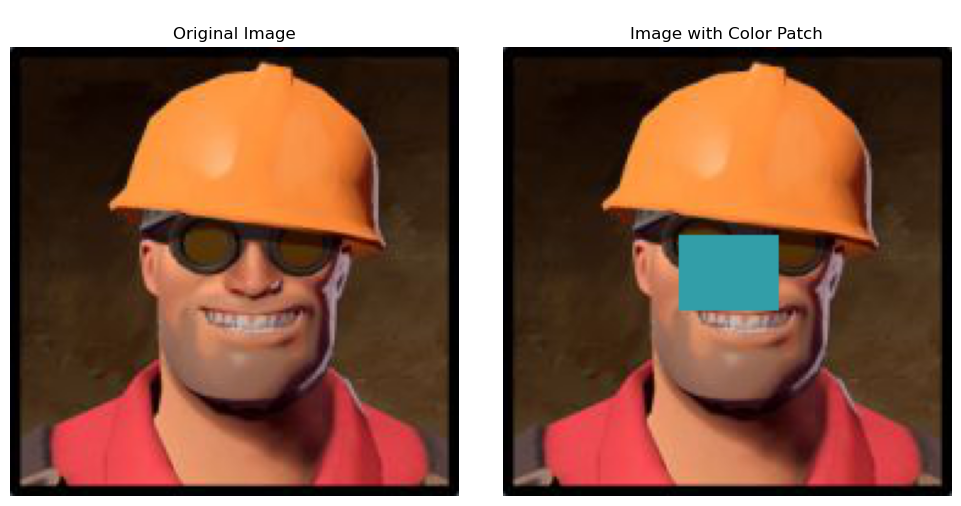

In [1]:
# QUESTION 1

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Got the image and displayed it
img = cv2.imread("tf2_engineer.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Got the center and intensity of the image
h, w, _ = img.shape
y_center = h // 2
x_center = w // 2
c_int = img[y_center, x_center]
print("Center coordinates:", (x_center, y_center))
print("Intensity at center (BGR):", c_int)

# Drew a patch in the middle
patch_color = (168, 158, 50)
p_h, p_w = 30, 40
top_left = (x_center - p_w // 2, y_center - p_h // 2)
bottom_right = (x_center + p_w // 2, y_center + p_h // 2)

img_patch = img.copy()
cv2.rectangle(img_patch, top_left, bottom_right, patch_color, thickness=-1)

# Printed the patch intensity
patch_center = img_patch[y_center, x_center]
print("Intensity at center of patch (BGR):", patch_center)

# Converted the modified image to RGB
img_patch_rgb = cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB)

# Displayed both images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("\nOriginal Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img_patch_rgb)
plt.title("Image with Color Patch")
plt.axis("off")
plt.tight_layout()
plt.show()


I got the image from the file, then converted it from BGR to RGB for a more accurate color display. 
Then I found the center of the image by dividing the height and width by 2, and printed the BGR intensity at the center pixel. 
The rectangle was drawn in the center using the requested color as shown in the comparison.

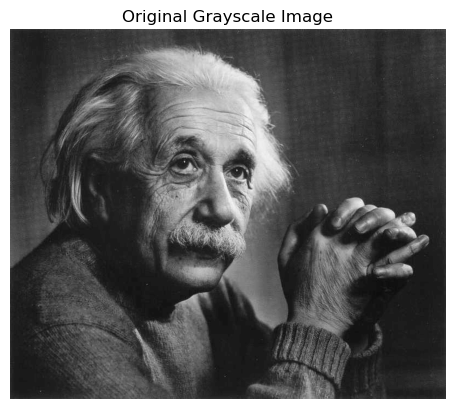

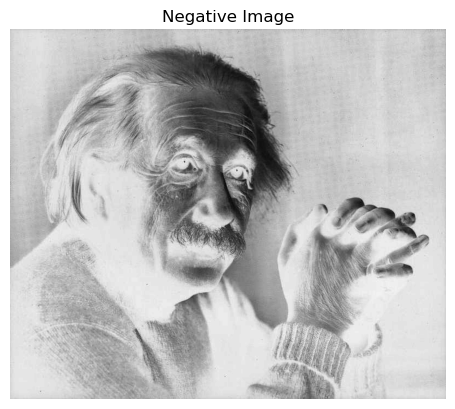

Random Pixel Intensity Comparisons (Original → Negative):
Pixel (361, 287): 122 → 133
Pixel (497, 377): 110 → 145
Pixel (416, 54): 109 → 146
Pixel (77, 390): 97 → 158
Pixel (657, 166): 102 → 153


In [3]:
# QUESTION 2

import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# Got and read the grayscale image
img_gray = cv2.imread("einstein.tif", cv2.IMREAD_GRAYSCALE)

# Displayed the original image
plt.imshow(img_gray, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis("off")
plt.show()

# Calculated and displayed the negative image
neg_img = 255 - img_gray

plt.imshow(neg_img, cmap='gray')
plt.title("Negative Image")
plt.axis("off")
plt.show()

# Picked 5 random pixel coordinates and compared their values
h, w = img_gray.shape
print("Random Pixel Intensity Comparisons (Original → Negative):")

for _ in range(5):
    x = random.randint(0, w - 1)
    y = random.randint(0, h - 1)
    
    ori_val = img_gray[y, x]
    neg_val = neg_img[y, x]
    
    print(f"Pixel ({x}, {y}): {ori_val} → {neg_val}")


I imported the image, read it in grayscale mode, and displayed it.  
To create the negative image, each pixel value was subtracted from 255, which inverts the brightness.  
Five random pixel coordinates were selected each time the code runs.  
The original and negative values were printed to show the effect of the transformation.

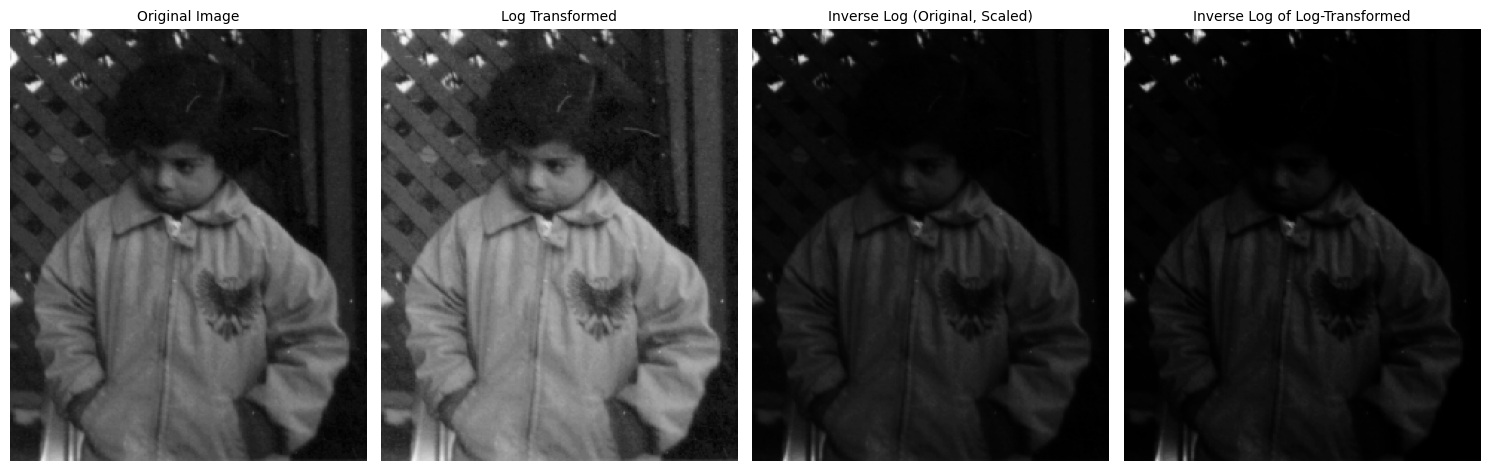

In [5]:
#QUESTION 3

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the originl grayscale image
img = cv2.imread("pout.tif", cv2.IMREAD_GRAYSCALE)

# Applied log transform
img_float = img.astype(np.float32)
log_transformed = np.log1p(img_float)  # log(1 + x)
log_normalized = cv2.normalize(log_transformed, None, 0, 255, cv2.NORM_MINMAX)
log_image = np.uint8(log_normalized)

# Applied inverse log of the original
scaled_img = img_float / 255.0
scaled_img *= 5  # simulate smaller range
inv_log_original = np.expm1(scaled_img)
inv_log_original_norm = cv2.normalize(inv_log_original, None, 0, 255, cv2.NORM_MINMAX)
inv_log_image_original = np.uint8(inv_log_original_norm)

# Inverse log of log-transformed image
log_rescaled = log_image.astype(np.float32) / 255.0
log_rescaled *= np.max(log_transformed)
inv_log_of_log = np.expm1(log_rescaled)
inv_log_of_log_norm = cv2.normalize(inv_log_of_log, None, 0, 255, cv2.NORM_MINMAX)
inv_log_of_log_img = np.uint8(inv_log_of_log_norm)

# Displayed all results side-by-side
titles = [
    "Original Image",
    "Log Transformed",
    "Inverse Log (Original, Scaled)",
    "Inverse Log of Log-Transformed"
]
images = [img, log_image, inv_log_image_original, inv_log_of_log_img]

plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i], fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()


For this one, I loaded the image in grayscale and applied a log transformation. This helps bring out details in the darker areas by compressing the brighter parts of the image. To avoid overflow when applying the inverse log, I scaled the original image first. 
Then I also tried applying the inverse log to the log-transformed image,but had to reverse the normalization first so it would make sense. 
I displayed all four versions side by side to clearly see how each step changes the image.


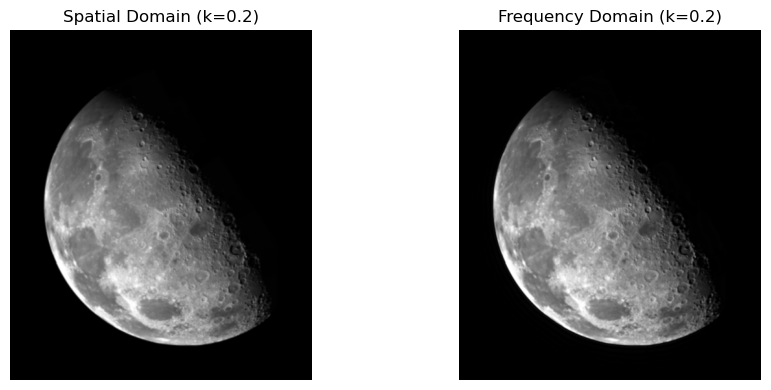

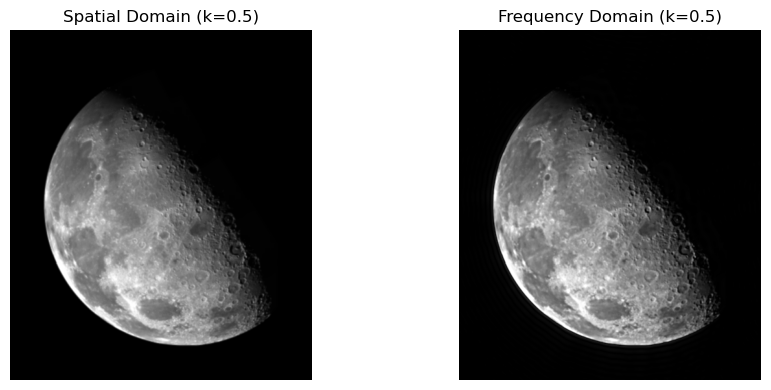

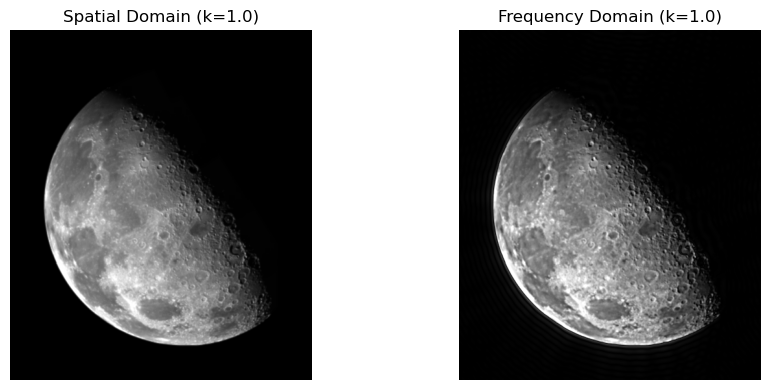

In [7]:
#QUESTION 4

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Imported the image
img = cv2.imread("moon.tif", cv2.IMREAD_GRAYSCALE)

# Applied Spatial unsharp masking
def unsharp_mask_spatial(img, k):
    blurred = cv2.GaussianBlur(img, (5, 5), 1.0)
    mask = cv2.subtract(img, blurred)
    sharp = cv2.addWeighted(img, 1.0, mask, k, 0)
    return sharp

# Applied Frequency domain unsharp masking
def high_pass_filter(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.float32)
    for u in range(rows):
        for v in range(cols):
            D = np.sqrt((u - crow) ** 2 + (v - ccol) ** 2)
            if D < cutoff:
                mask[u, v] = 0
    return mask

def unsharp_mask_frequency(img, k, D0):
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    hpf = high_pass_filter(img.shape, D0)
    result_shift = (1 + k * hpf) * dft_shift
    result_ishift = np.fft.ifftshift(result_shift)
    img_back = np.fft.ifft2(result_ishift)
    img_back = np.abs(img_back)
    img_back = np.uint8(np.clip(img_back, 0, 255))
    return img_back

# Applyed both methods for each k and displayed comparisons side by side
k_values = [0.2, 0.5, 1.0]
D0 = 30  # frequency cutoff

for k in k_values:
    spatial_result = unsharp_mask_spatial(img, k)
    frequency_result = unsharp_mask_frequency(img, k, D0)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(spatial_result, cmap='gray')
    plt.title(f"Spatial Domain (k={k})")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(frequency_result, cmap='gray')
    plt.title(f"Frequency Domain (k={k})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

I used unsharp masking to sharpen the MOON image using two different approaches: spatial domain and frequency domain. 
For both methods, I tested three different values of "k" (0.2, 0.5, 1.0) to see how the sharpening intensity changes. 
For each value of k, I displayed the result from the spatial method side-by-side with the result from the frequency method. 
This makes it easy to compare how each technique affects the image. 


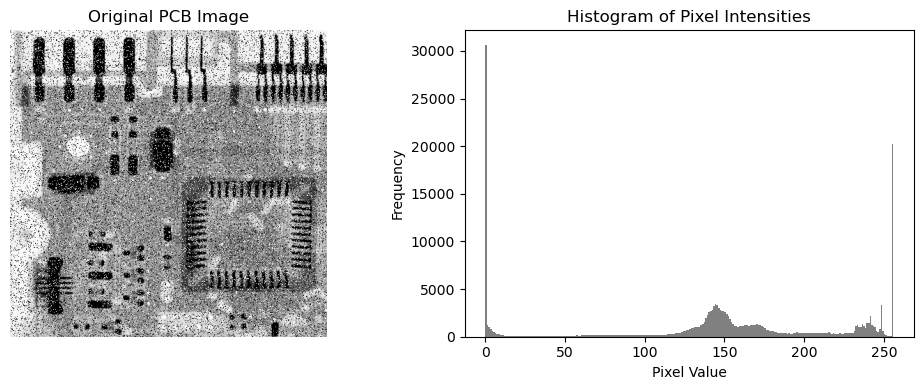

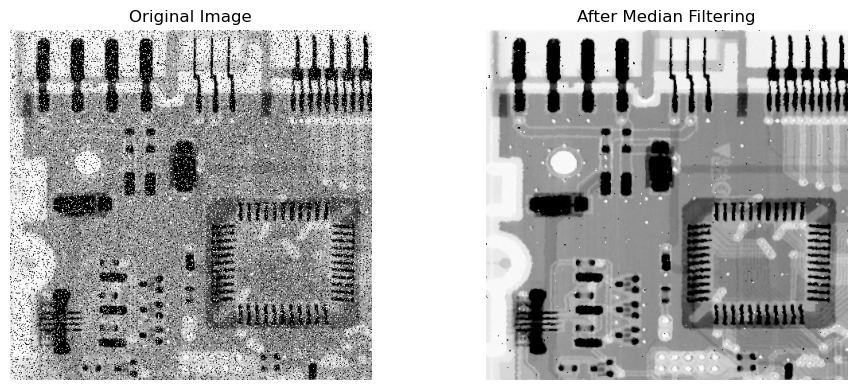

In [9]:
#QUESTION 5

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read grayscale image
img = cv2.imread("pcb.tif", cv2.IMREAD_GRAYSCALE)

# Showed the Histogram for statistical noise inspection
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original PCB Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(img.ravel(), bins=256, range=[0, 256], color='gray')
plt.title("Histogram of Pixel Intensities")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Applyed filters to compare them
median_filtered = cv2.medianBlur(img, 3)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(median_filtered, cmap='gray')
plt.title("After Median Filtering")
plt.axis("off")

plt.tight_layout()
plt.show()


This image had visible salt-and-pepper noise, confirmed by the speckled appearance and histogram spikes near 0 and 255. I used a median filter, which is ideal for this type of noise, as it removes outliers while preserving edges. The result shows a much cleaner image while keeping important PCB details.

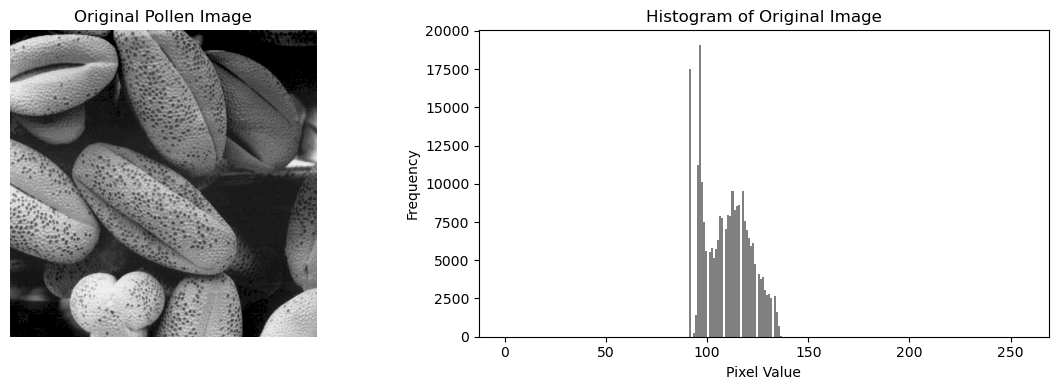

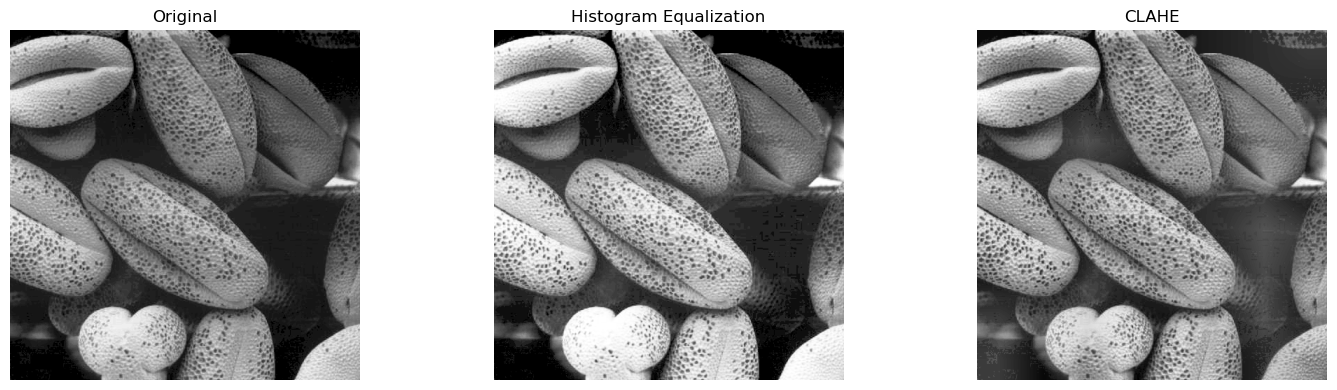

In [11]:
#QUESTION 6

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read and displayed the grayscale image
img = cv2.imread("pollen.tif", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Pollen Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.hist(img.ravel(), bins=256, range=[0, 256], color='gray')
plt.title("Histogram of Original Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Method 1 - Histogram Equalization
hist_eq = cv2.equalizeHist(img)

# Method 2 - CLAHE
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(img)

# Show the comparison
titles = ["Original", "Histogram Equalization", "CLAHE"]
images = [img, hist_eq, clahe_img]

plt.figure(figsize=(15, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


This image had low contrast, which was clear from the dull appearance and the narrow range in the histogram. To fix this, I applied two different enhancement methods histogram equalization, and CLACHE. Both methods improved the image, but CLAHE gave a more balanced result by avoiding over-contrast and enhancing fine texture more naturally.